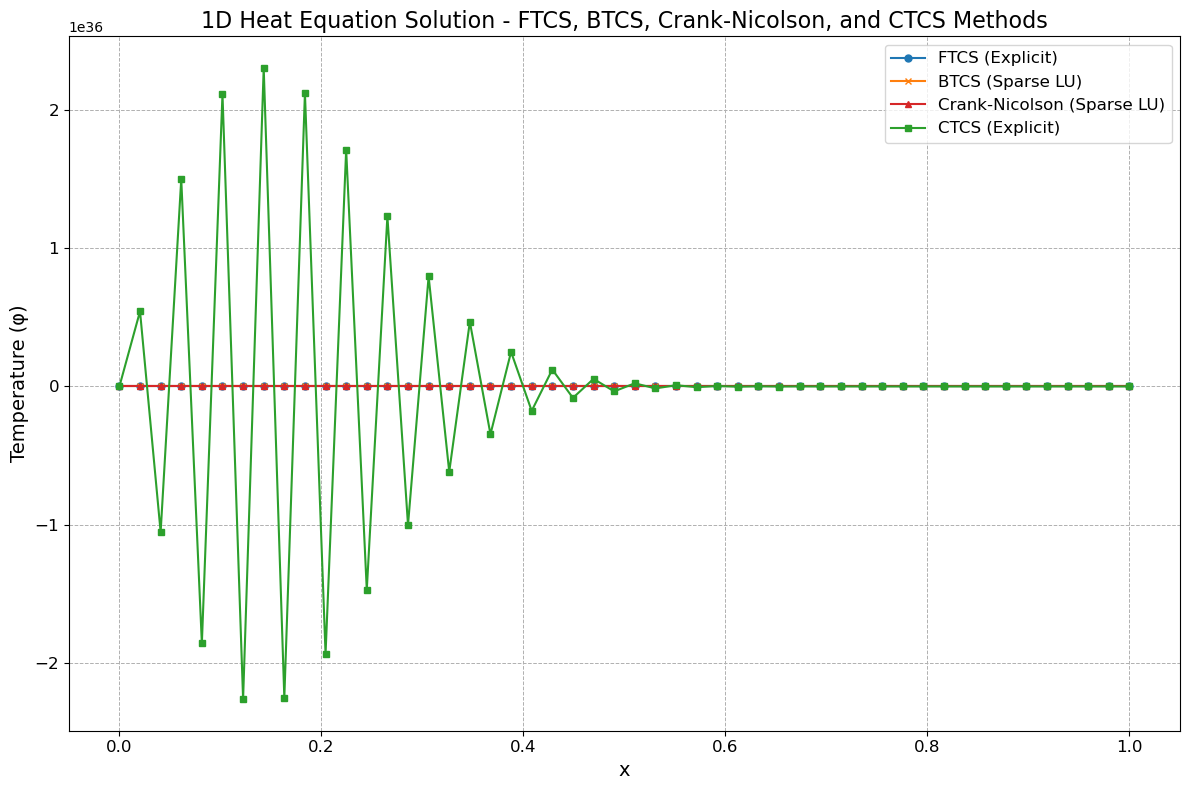

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu

# Define parameters
L = 1.0          # Length of the domain
T = 0.01          # Total simulation time
Nx = 50          # Number of spatial grid points
Nt = 1000        # Number of time steps
alpha = 1.0      # Thermal diffusivity
dx = L / (Nx - 1)  # Spatial step size
dt = T / Nt        # Time step size
r = alpha * dt / dx**2  # Stability parameter

# Check stability conditions
if r > 0.5:
    print("Warning: FTCS and CTCS may be unstable for r > 0.5. Adjust dx or dt.")


# Grid points
x = np.linspace(0, L, Nx)

# Initial and boundary conditions
u_initial = np.zeros(Nx)
u_initial[0] = 1  # Boundary condition at x=0 at t=0
u_initial[-1] = 0  # Boundary condition at x=L at t=0

# Sparse matrix for BTCS
diagonal_btcs = (1 + 2 * r) * np.ones(Nx)
off_diagonal_btcs = -r * np.ones(Nx - 1)
A_btcs = diags([off_diagonal_btcs, diagonal_btcs, off_diagonal_btcs], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
lu_btcs = splu(A_btcs)  # LU decomposition for BTCS

# Sparse matrix for Crank-Nicolson
diagonal_cn = (1 + r) * np.ones(Nx)
off_diagonal_cn = -r / 2 * np.ones(Nx - 1)
A_cn = diags([off_diagonal_cn, diagonal_cn, off_diagonal_cn], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()

# Sparse matrix for CTCS
diagonal_ctcs = (1 + r) * np.ones(Nx)
off_diagonal_ctcs = -r * np.ones(Nx - 1)
A_ctcs = diags([off_diagonal_ctcs, diagonal_ctcs, off_diagonal_ctcs], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()

# FTCS with explicit time-stepping
def solve_ftcs_lu():
    u = u_initial.copy()
    for n in range(1, Nt):
        u_new = u + r * (np.roll(u, -1) - 2*u + np.roll(u, 1))  # Explicit update
        u_new[0] = 1  # Boundary condition at x=0
        u_new[-1] = 0  # Boundary condition at x=L
        u = u_new
    return u

# BTCS with LU decomposition (solving system of equations)
def solve_btcs_lu():
    u = u_initial.copy()
    for n in range(1, Nt):
        b = u.copy()
        b[0] = 1  # Boundary condition at x=0
        b[-1] = 0  # Boundary condition at x=L
        u = lu_btcs.solve(b)  # Solve using LU decomposition
        u[0] = 1  # Enforce boundary condition at x=0
        u[-1] = 0  # Enforce boundary condition at x=L
    return u

# Crank-Nicolson method (sparse LU method)
def solve_crank_nicolson_lu():
    u_prev = u_initial.copy()  # u^{n-1}
    u_curr = u_initial.copy()  # u^n
    u_next = u_initial.copy()  # u^{n+1}
    
    # Initial time step using FTCS for Crank-Nicolson
    u_next = u_curr + r * (np.roll(u_curr, -1) - 2*u_curr + np.roll(u_curr, 1))  # FTCS update for first step
    u_next[0] = 1  # Boundary condition at x=0
    u_next[-1] = 0  # Boundary condition at x=L
    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    # Main Crank-Nicolson loop
    for n in range(2, Nt):
        # Set up right-hand side vector (b) using the Crank-Nicolson scheme
        b = (1 - r) * u_curr + (r) * (np.roll(u_prev, 1) + np.roll(u_prev, -1))
        b[0] = 1  # Boundary condition at x=0
        b[-1] = 0  # Boundary condition at x=L
        u_next = lu_btcs.solve(b)  # Solve using LU decomposition for the system
        u_prev = u_curr.copy()
        u_curr = u_next.copy()

        # Enforce boundary conditions
        u_next[0] = 1  # Boundary condition at x=0
        u_next[-1] = 0  # Boundary condition at x=L

    return u_curr

# CTCS method (explicit scheme)
def solve_ctcs():
    u_prev = u_initial.copy()  # u^{n-1}
    u_curr = u_initial.copy()  # u^n
    u_next = u_initial.copy()  # u^{n+1}
    
    # Initial time step using FTCS for CTCS
    u_next = u_curr + r * (np.roll(u_curr, -1) - 2*u_curr + np.roll(u_curr, 1))  # FTCS update for first step
    u_next[0] = 1  # Boundary condition at x=0
    u_next[-1] = 0  # Boundary condition at x=L
    u_prev = u_curr.copy()
    u_curr = u_next.copy()

    # Main CTCS loop (explicit)
    for n in range(2, Nt):
        u_next = u_prev + 2 * r * (np.roll(u_curr, 1) - 2 * u_curr + np.roll(u_curr, -1))  # CTCS update
        u_next[0] = 1  # Boundary condition at x=0
        u_next[-1] = 0  # Boundary condition at x=L
        u_prev = u_curr.copy()
        u_curr = u_next.copy()

    return u_curr

# Solve using all methods
u_ftcs_lu = solve_ftcs_lu()
u_btcs_lu = solve_btcs_lu()
u_crank_nicolson_lu = solve_crank_nicolson_lu()
u_ctcs = solve_ctcs()

# Plot results
plt.figure(figsize=(12, 8))

# FTCS
plt.plot(x, u_ftcs_lu, label='FTCS (Explicit)', linestyle='-', color='tab:blue', marker='o', markersize=5)

# BTCS
plt.plot(x, u_btcs_lu, label='BTCS (Sparse LU)', linestyle='-', color='tab:orange', marker='x', markersize=5)

# Crank-Nicolson
plt.plot(x, u_crank_nicolson_lu, label='Crank-Nicolson (Sparse LU)', linestyle='-', color='tab:red', marker='^', markersize=5)

# CTCS
plt.plot(x, u_ctcs, label='CTCS (Explicit)', linestyle='-', color='tab:green', marker='s', markersize=5)

# Labels and title
plt.xlabel('x', fontsize=14)
plt.ylabel('Temperature (φ)', fontsize=14)
plt.title('1D Heat Equation Solution - FTCS, BTCS, Crank-Nicolson, and CTCS Methods', fontsize=16)

# Improve grid and ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
